In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [134]:
from lime.lime_tabular import LimeTabularExplainer
import shap
import warnings
warnings.filterwarnings('ignore')

In [135]:
iris = load_iris()
X = iris['data']
y = iris['target']
feature_names = iris['feature_names']
class_names = iris['target_names']

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [137]:
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [138]:
torch.manual_seed(42)
device = torch.device('cpu')

In [139]:
Xtr_t = torch.tensor(X_train_std, dtype=torch.float32).to(device)
ytr_t = torch.tensor(y_train, dtype=torch.long).to(device)
Xte_t = torch.tensor(X_test_std, dtype=torch.float32).to(device)
yte_t = torch.tensor(y_test, dtype=torch.long).to(device)

In [140]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 3)
).to(device)

In [141]:
criterion = nn.CrossEntropyLoss() # MSE, MAE
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 300

In [142]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(Xtr_t)
    loss = criterion(logits, ytr_t)
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    logits_te = model(Xte_t)
    ypred = logits_te.argmax(dim=1).cpu().numpy()

In [144]:
from sklearn.metrics import accuracy_score

In [145]:
print(f'Acc score: {accuracy_score(y_test, ypred)}')
print(classification_report(y_test, ypred, target_names=class_names))

Acc score: 0.9333333333333333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



## XAI

### Wrapper predict

In [ ]:
softmax = nn.Softmax(dim=1)
def predict_proba_numpy(X_numpy):
    model.eval()
    Xs = scaler.transform(X_numpy)
    Xt = torch.tensor(Xs, dtype=torch.float32).to(device)
    with torch.no_grad():
        probs = softmax(model(Xt)).cpu().numpy()

    return probs

## LIME

In [181]:
from lime.lime_tabular import LimeTabularExplainer
explainer_lime = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=list(class_names),
    discretize_continuous=True,
    mode='classification'
)

In [182]:
idx = 5
x0 = X_test[idx]
x0_std = X_test_std[idx]
y0 = y_test[idx]

In [183]:
def predict_proba_raw(X_raw):
    return predict_proba_numpy(X_raw)

In [184]:
lime_exp = explainer_lime.explain_instance(
    data_row=x0,
    predict_fn=predict_proba_raw,
    num_features=4
)

In [185]:
print(f'\n[LIME] Explaintation for instance idx = {idx}')
print(f'True class: {class_names[y0]}')
print(f'Pred proba: {predict_proba_raw(x0.reshape(1, -1))[0]}')
lime_exp.as_list()


[LIME] Explaintation for instance idx = 5
True class: versicolor
Pred proba: [0.01248827 0.5665273  0.4209844 ]


[('sepal width (cm) > 3.32', -0.08217067709105956),
 ('4.30 < petal length (cm) <= 5.10', 0.08211299477082125),
 ('1.30 < petal width (cm) <= 1.82', 0.06831474098425741),
 ('5.80 < sepal length (cm) <= 6.40', 0.022582725482409402)]

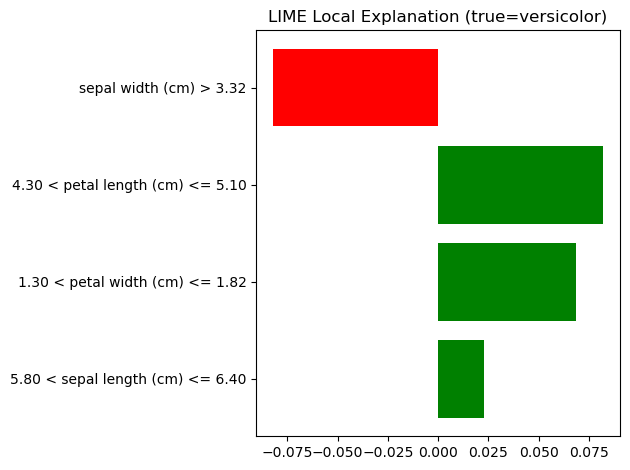

In [186]:
fig_lime = lime_exp.as_pyplot_figure()
plt.title(f"LIME Local Explanation (true={class_names[y0]})")
plt.tight_layout()
plt.savefig("lime_iris_instance.png", dpi=140)
plt.show()

# SHAP

In [187]:
rng = np.random.default_rng(42)
m = min(50, X_train.shape[0])                 # mis. 50 baris
bg_idx = rng.choice(X_train.shape[0], size=m, replace=False)  # ← sample dari JUMLAH BARIS
background = X_train[bg_idx]   

In [188]:
# Pilih beberapa titik background (wajib kecil agar cepat)
explainer_shap = shap.KernelExplainer(predict_proba_raw, background)

In [189]:
# Jelaskan 1 instance (x0)
shap_values_x0 = explainer_shap.shap_values(x0.reshape(1, -1), nsamples=300)

  0%|          | 0/1 [00:00<?, ?it/s]

In [190]:
print("\n[SHAP] Per-class shap values for the same instance:")
sv2d = np.asarray(shap_values_x0)        # pastikan ndarray (4,3)
for k, cname in enumerate(class_names):
    vals = sv2d[:, k]                    # <-- ambil kolom kelas -> 4 angka (1/ftr)
    pairs = dict(zip(feature_names, np.round(vals, 3)))
    print(f"  Class={cname} | SHAP per-feature: {pairs}")


[SHAP] Per-class shap values for the same instance:
  Class=setosa | SHAP per-feature: {'sepal length (cm)': array([-0.058,  0.077, -0.019])}
  Class=versicolor | SHAP per-feature: {'sepal length (cm)': array([ 0.   ,  0.007, -0.007])}
  Class=virginica | SHAP per-feature: {'sepal length (cm)': array([-0.135,  0.102,  0.032])}


In [195]:
# pastikan bentuknya 2D (4 fitur x 3 kelas)
sv2d = np.asarray(shap_values_x0)        # -> (4, 3)
print("shap_values_x0 shape:", sv2d.shape)

# kelas terprediksi
probs0 = predict_proba_raw(x0.reshape(1,-1))[0]
pred_class = int(np.argmax(probs0))

# vektor kontribusi 4 fitur untuk kelas terprediksi
sv = sv2d[:, pred_class]                 # <-- ambil kolom kelas
local_vals = np.abs(sv)
order = np.argsort(local_vals)[::-1]

shap_values_x0 shape: (1, 4, 3)


In [210]:
order[0]

array([0, 1, 2])

In [216]:
range(len(feature_names))

range(0, 4)

In [226]:
sv2d = np.asarray(shap_values_x0).squeeze(0)
sv2d

array([[-0.05791457,  0.07706946, -0.01915489],
       [ 0.00029853,  0.00695572, -0.00725425],
       [-0.13467988,  0.10248288,  0.03219699],
       [-0.16295824,  0.12171894,  0.0412393 ]])

In [231]:
order = np.argsort(local_vals)[::-1]

In [232]:
order

array([3, 2, 0, 1])

shap_values_x0 shape: (4, 3)


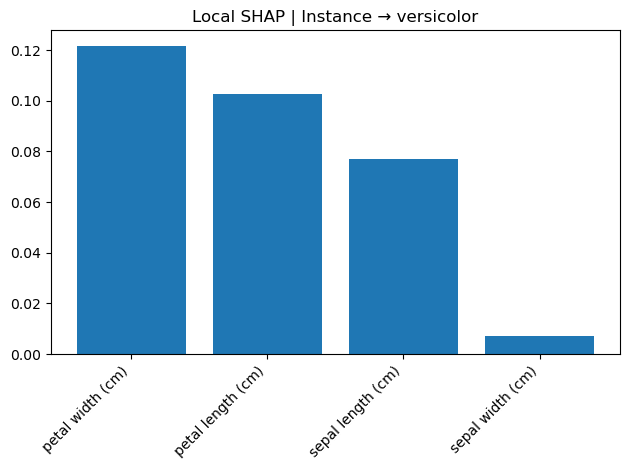

Saved: shap_local_bar.png shap_force_instance.html


In [222]:
import numpy as np
import matplotlib.pyplot as plt

# pastikan bentuknya 2D (4 fitur x 3 kelas)
sv2d = np.asarray(shap_values_x0).squeeze(0)        # -> (4, 3)
print("shap_values_x0 shape:", sv2d.shape)

# kelas terprediksi
probs0 = predict_proba_raw(x0.reshape(1,-1))[0]
pred_class = int(np.argmax(probs0))

# vektor kontribusi 4 fitur untuk kelas terprediksi
sv = sv2d[:, pred_class]                 # <-- ambil kolom kelas
local_vals = np.abs(sv)
order = np.argsort(local_vals)[::-1]

# bar chart lokal
plt.figure()
plt.bar(range(len(feature_names)), local_vals[order])
plt.xticks(range(len(feature_names)), np.array(feature_names)[order], rotation=45, ha='right')
plt.title(f"Local SHAP | Instance → {class_names[pred_class]}")
plt.tight_layout(); plt.savefig("shap_local_bar.png", dpi=140)
plt.show()

# force plot (HTML interaktif)
shap.initjs()
fp = shap.force_plot(
    explainer_shap.expected_value[pred_class],  # expected value utk kelas prediksi
    sv,                                         # kontribusi fitur (arah + besar)
    x0, feature_names=feature_names
)
shap.save_html("shap_force_instance.html", fp)
print("Saved:", "shap_local_bar.png", "shap_force_instance.html")


  0%|          | 0/38 [00:00<?, ?it/s]

subset SHAP shape: (38, 4, 3)


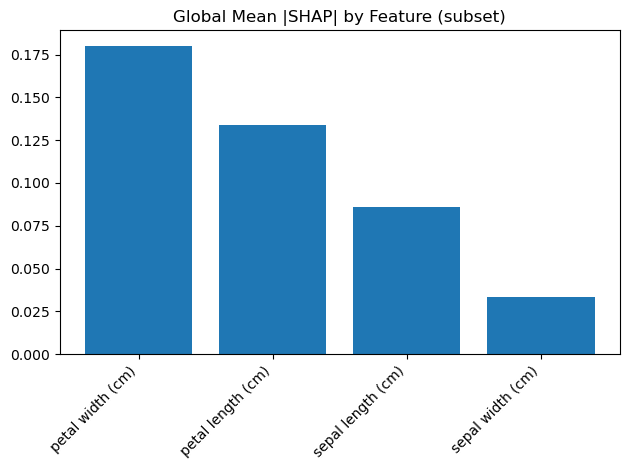

Saved: shap_global_bar.png


In [223]:
# hitung SHAP utk subset test biar cepat
subset = X_test[:40]
sv_sub = np.asarray(explainer_shap.shap_values(subset, nsamples=200))  # (N, F, C)
print("subset SHAP shape:", sv_sub.shape)

# kelas prediksi tiap sampel
preds = np.argmax(predict_proba_raw(subset), axis=1)

# rata-rata kontribusi absolut per fitur mengikuti kelas prediksi masing-masing sampel
mean_abs = np.mean([np.abs(sv_sub[i, :, preds[i]]) for i in range(subset.shape[0])], axis=0)

order_g = np.argsort(mean_abs)[::-1]
plt.figure()
plt.bar(range(len(feature_names)), mean_abs[order_g])
plt.xticks(range(len(feature_names)), np.array(feature_names)[order_g], rotation=45, ha='right')
plt.title("Global Mean |SHAP| by Feature (subset)")
plt.tight_layout(); plt.savefig("shap_global_bar.png", dpi=140)
plt.show()

print("Saved:", "shap_global_bar.png")


In [146]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [147]:
# !pip install lime shap

In [148]:

from lime.lime_tabular import LimeTabularExplainer
import shap
import warnings
warnings.filterwarnings("ignore")

In [149]:
iris = load_iris()
X = iris['data']
y = iris['target']
feature_names = iris['feature_names']  # ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
class_names = iris['target_names']     # ['setosa', 'versicolor', 'virginica']


In [150]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [151]:
from sklearn.preprocessing import MinMaxScaler

In [152]:
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [153]:
torch.manual_seed(42)
device = torch.device("cpu")

In [154]:
Xtr_t = torch.tensor(X_train_std, dtype=torch.float32).to(device)
ytr_t = torch.tensor(y_train, dtype=torch.long).to(device)
Xte_t = torch.tensor(X_test_std,  dtype=torch.float32).to(device)
yte_t = torch.tensor(y_test, dtype=torch.long).to(device)

In [155]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 3)   # 3 kelas
).to(device)


In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 300

In [157]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(Xtr_t)
    loss = criterion(logits, ytr_t)
    loss.backward()
    optimizer.step()

In [158]:
model.eval()
with torch.no_grad():
    logits_te = model(Xte_t)
    ypred = logits_te.argmax(dim=1).cpu().numpy()

In [159]:
print("Accuracy:", accuracy_score(y_test, ypred))
print(classification_report(y_test, ypred, target_names=class_names))

Accuracy: 0.9210526315789473
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



## Wrapper predict for XAI

In [160]:
softmax = nn.Softmax(dim=1)

In [161]:
def predict_proba_numpy(X_numpy):
    model.eval()
    Xs = scaler.transform(X_numpy)
    Xt = torch.tensor(Xs, dtype=torch.float32).to(device)
    with torch.no_grad():
        probs = softmax(model(Xt)).cpu().numpy()
    return probs

## LIME

In [162]:
from lime.lime_tabular import LimeTabularExplainer

In [163]:
explainer_lime = LimeTabularExplainer(
    training_data=X_train,               # [FIX] pakai RAW agar konsisten dgn predict_proba_numpy (yang melakukan scaling)
    feature_names=feature_names,
    class_names=list(class_names),
    discretize_continuous=True,
    mode='classification'
)

In [164]:
idx = 5
x0 = X_test[idx]           # raw
x0_std = X_test_std[idx]   # standardized (tak dipakai langsung oleh LIME)
y0 = y_test[idx]

In [165]:
# LIME butuh fungsi predict_proba yang menerima RAW (belum di-scale), untuk di scaling
# jadi kita bungkus fungsi di atas dengan penyesuaian internal scaling.
def predict_proba_raw(X_raw):
    return predict_proba_numpy(X_raw)

In [166]:
lime_exp = explainer_lime.explain_instance(
    data_row=x0,               # raw row (LIME yang melakukan discretization/perturbation)
    predict_fn=predict_proba_raw,
    num_features=4,
)

In [167]:
print("\n[LIME] Explanation for instance idx =", idx)
print("True class:", class_names[y0])
print("Pred proba:", predict_proba_raw(x0.reshape(1,-1))[0])
lime_exp.as_list()


[LIME] Explanation for instance idx = 5
True class: versicolor
Pred proba: [0.01248827 0.5665273  0.4209844 ]


[('4.30 < petal length (cm) <= 5.10', 0.08899667739813479),
 ('sepal width (cm) > 3.32', -0.07542770793291541),
 ('1.30 < petal width (cm) <= 1.82', 0.06578039250134254),
 ('5.80 < sepal length (cm) <= 6.40', 0.02397340407455005)]

In [168]:
import matplotlib.pyplot as plt


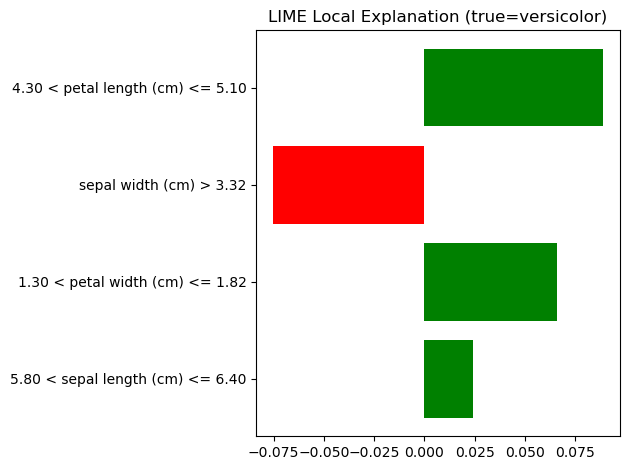

In [169]:
fig_lime = lime_exp.as_pyplot_figure()
plt.title(f"LIME Local Explanation (true={class_names[y0]})")
plt.tight_layout()
plt.savefig("lime_iris_instance.png", dpi=140)
plt.show()

## SHAAPPPPP 🫡

In [170]:
X_train.shape[0]

112

In [171]:
X_train.shape[1]

4

In [172]:
rng = np.random.default_rng(42)
m = min(50, X_train.shape[0])                 # mis. 50 baris
bg_idx = rng.choice(X_train.shape[0], size=m, replace=False)  # ← sample dari JUMLAH BARIS
background = X_train[bg_idx]   

In [173]:
# Pilih beberapa titik background (wajib kecil agar cepat)
explainer_shap = shap.KernelExplainer(predict_proba_raw, background)

In [174]:
x0.reshape(1, -1)

array([[6. , 3.4, 4.5, 1.6]])

In [175]:
# Jelaskan 1 instance (x0)
shap_values_x0 = explainer_shap.shap_values(x0.reshape(1, -1), nsamples=300)

  0%|          | 0/1 [00:00<?, ?it/s]

In [176]:
shap_values_x0

array([[[-0.05791457,  0.07706946, -0.01915489],
        [ 0.00029853,  0.00695572, -0.00725425],
        [-0.13467988,  0.10248288,  0.03219699],
        [-0.16295824,  0.12171894,  0.0412393 ]]])

In [177]:
for k, cname in enumerate(class_names):
    print(k, ' ', cname)

0   setosa
1   versicolor
2   virginica


In [178]:
shap_values_x0

array([[[-0.05791457,  0.07706946, -0.01915489],
        [ 0.00029853,  0.00695572, -0.00725425],
        [-0.13467988,  0.10248288,  0.03219699],
        [-0.16295824,  0.12171894,  0.0412393 ]]])

In [179]:
print("\n[SHAP] Per-class shap values for the same instance:")
sv2d = np.asarray(shap_values_x0)        # pastikan ndarray (4,3)
for k, cname in enumerate(class_names):
    vals = sv2d[:, k]                    # <-- ambil kolom kelas -> 4 angka (1/ftr)
    pairs = dict(zip(feature_names, np.round(vals, 3)))
    print(f"  Class={cname} | SHAP per-feature: {pairs}")


[SHAP] Per-class shap values for the same instance:
  Class=setosa | SHAP per-feature: {'sepal length (cm)': array([-0.058,  0.077, -0.019])}
  Class=versicolor | SHAP per-feature: {'sepal length (cm)': array([ 0.   ,  0.007, -0.007])}
  Class=virginica | SHAP per-feature: {'sepal length (cm)': array([-0.135,  0.102,  0.032])}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pastikan bentuknya 2D (4 fitur x 3 kelas)
sv2d = np.asarray(shap_values_x0)        # -> (4, 3)
print("shap_values_x0 shape:", sv2d.shape)

# kelas terprediksi
probs0 = predict_proba_raw(x0.reshape(1,-1))[0]
pred_class = int(np.argmax(probs0))

# vektor kontribusi 4 fitur untuk kelas terprediksi
sv = sv2d[:, pred_class]                 # <-- ambil kolom kelas
local_vals = np.abs(sv)
order = np.argsort(local_vals)[::-1]

# bar chart lokal
plt.figure()
plt.bar(range(len(feature_names)), local_vals[order])
plt.xticks(range(len(feature_names)), np.array(feature_names)[order], rotation=45, ha='right')
plt.title(f"Local SHAP | Instance → {class_names[pred_class]}")
plt.tight_layout(); plt.savefig("shap_local_bar.png", dpi=140)
plt.show()

# force plot (HTML interaktif)
shap.initjs()
fp = shap.force_plot(
    explainer_shap.expected_value[pred_class],  # expected value utk kelas prediksi
    sv,                                         # kontribusi fitur (arah + besar)
    x0, feature_names=feature_names
)
shap.save_html("shap_force_instance.html", fp)
print("Saved:", "shap_local_bar.png", "shap_force_instance.html")


shap_values_x0 shape: (1, 4, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 640x480 with 0 Axes>

  0%|          | 0/38 [00:00<?, ?it/s]

subset SHAP shape: (38, 4, 3)


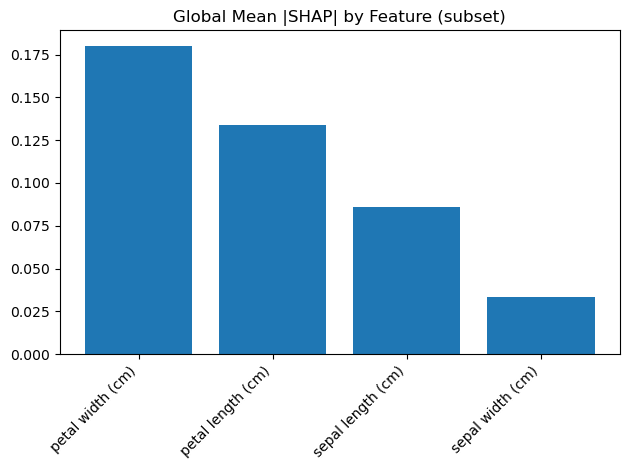

Saved: shap_global_bar.png


In [ ]:
# hitung SHAP utk subset test biar cepat
subset = X_test[:40]
sv_sub = np.asarray(explainer_shap.shap_values(subset, nsamples=200))  # (N, F, C)
print("subset SHAP shape:", sv_sub.shape)

# kelas prediksi tiap sampel
preds = np.argmax(predict_proba_raw(subset), axis=1)

# rata-rata kontribusi absolut per fitur mengikuti kelas prediksi masing-masing sampel
mean_abs = np.mean([np.abs(sv_sub[i, :, preds[i]]) for i in range(subset.shape[0])], axis=0)

order_g = np.argsort(mean_abs)[::-1]
plt.figure()
plt.bar(range(len(feature_names)), mean_abs[order_g])
plt.xticks(range(len(feature_names)), np.array(feature_names)[order_g], rotation=45, ha='right')
plt.title("Global Mean |SHAP| by Feature (subset)")
plt.tight_layout(); plt.savefig("shap_global_bar.png", dpi=140)
plt.show()

print("Saved:", "shap_global_bar.png")
